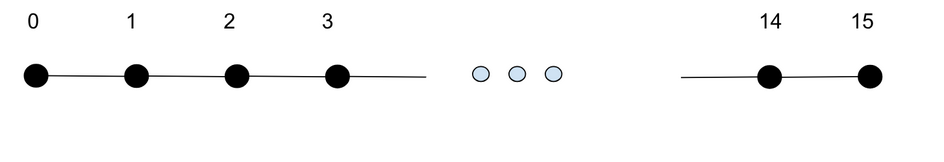

Quantum Walk on the Line

In [ ]:
import classiq
classiq.authenticate()

In [31]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences
import numpy as np

# 4 qbits requied to store 16 vertices
size = 4


#function to prepare |-> state
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)
    

    
#diffuser which change the phase to -1 whenever |j> =|0>
"""--------------------------------------------------------""" 
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
"""--------------------------------------------------------""" 




def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    #initialize the initial probability vector
    prob = list(np.zeros(2**size))
    
    #if at first vertex move to next with 1 prob.
    if i == 0:
        prob[i+1] = 1
    
    #if at last vertex move to prev. with 1 prob.
    #otherwise move left or right one vertex with equal prob.
    if i == 2**size - 1:
        prob[i-1] = 1
    elif i>0:
        prob[i-1]=0.5
        prob[i+1]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    #with |j> as control apply U (2|0><0| - 1) Dagger(U) |j>, where U|j> = 1/deg(k) * sum_{k} (|k> : j & k are connected ).
    #the inforamtion about connections is encoded in prob vectors.
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

    """---------------------------------------------------------""" 

#function which change qubit res if the vertices are connected. |j-k| = 1
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (vertices-adjacent_vertices)**2 ==1

    

#fucntion which take |j,k> -> |k,j>
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  
#S operator: If vertices are connected perform then perform the bitwise swap
#apply bitwise_swap if res = 1
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))
    
#main fucntion to allocate vertices and adjacent vertices 4 qubits each
#create a uniform superposition of vertices
#apply W and S operator
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=1, prob vec =[0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=2, prob vec =[0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=3, prob vec =[0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=4, prob vec =[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=5, prob vec =[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=6, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=7, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=8, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=9, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]
St

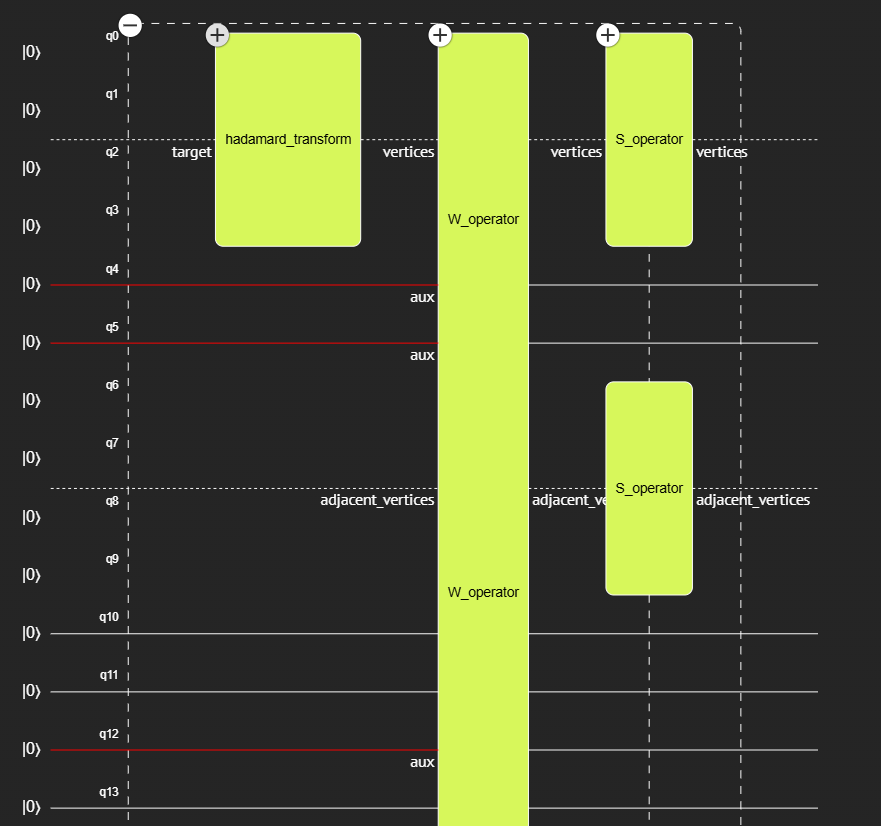

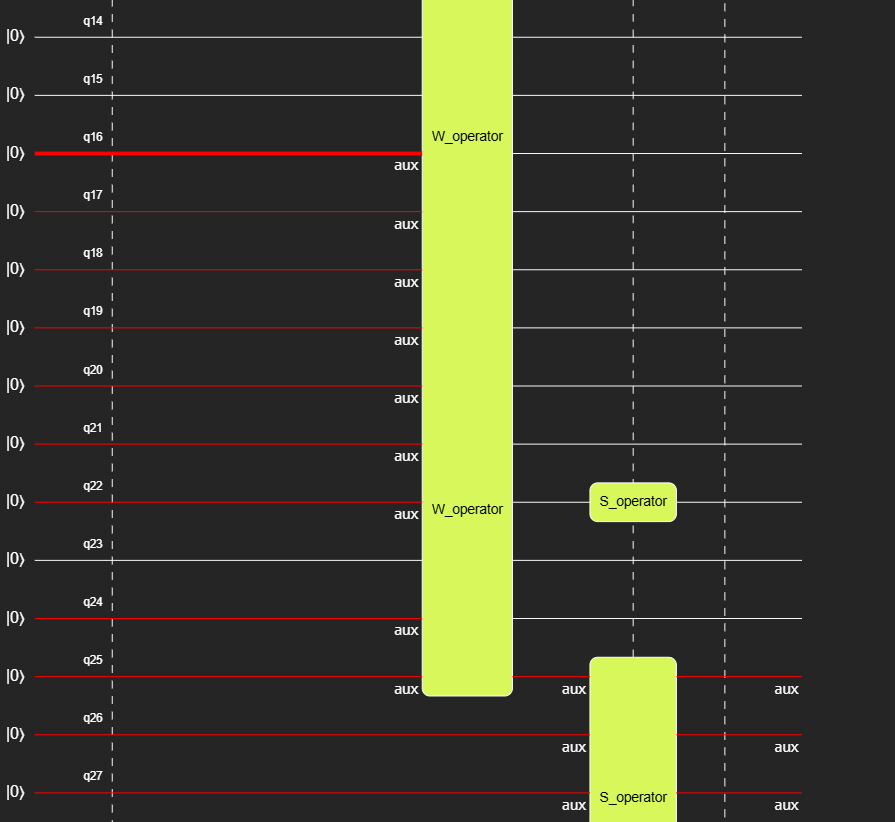

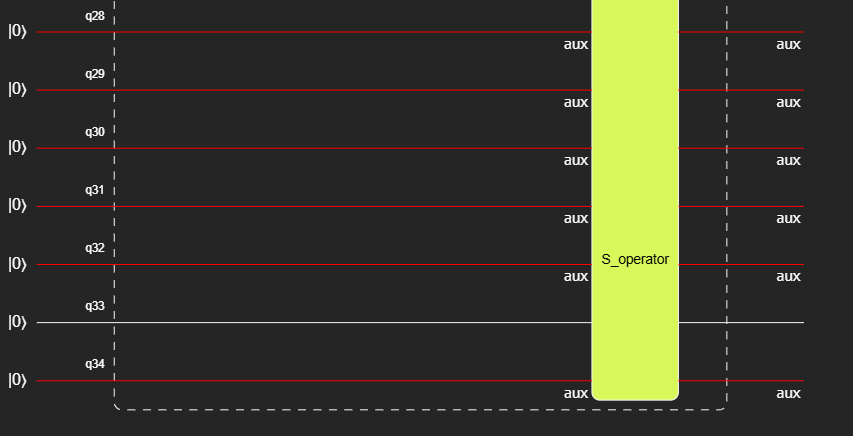

Full-Circuit implementation of the Quantum Walk

Depth of the Circuit is 5358 

Width of the Circuit is 37 

Gate Count is 

H : 914
X : 538
T : 764
CX : 2099
TDG : 635


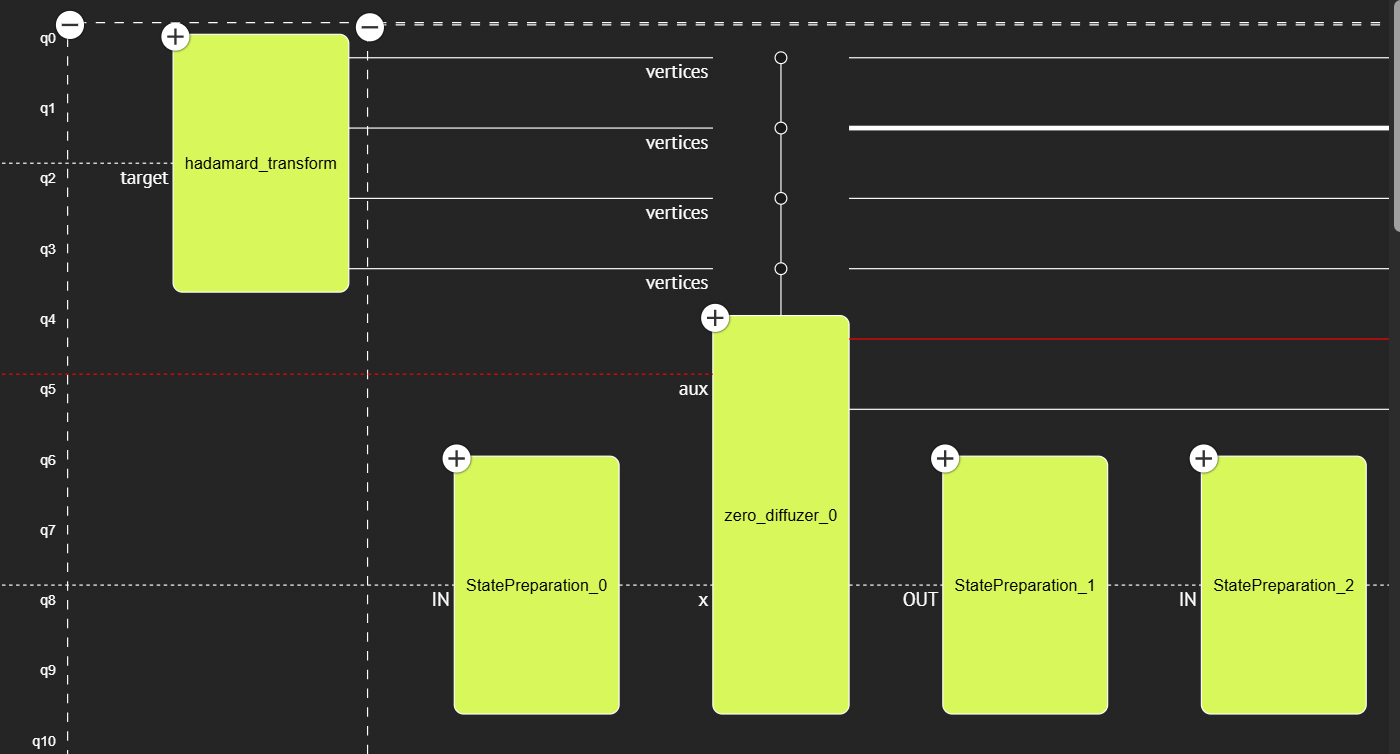

Single Iteration of the W Operator: Zero_diffuser is controlled by vertices qubits acts on adjacent vertices with conjugation of U = State Preparation Unitary, The W operator prepare the possible transition amplitude of the Walker to move into connected vertices.

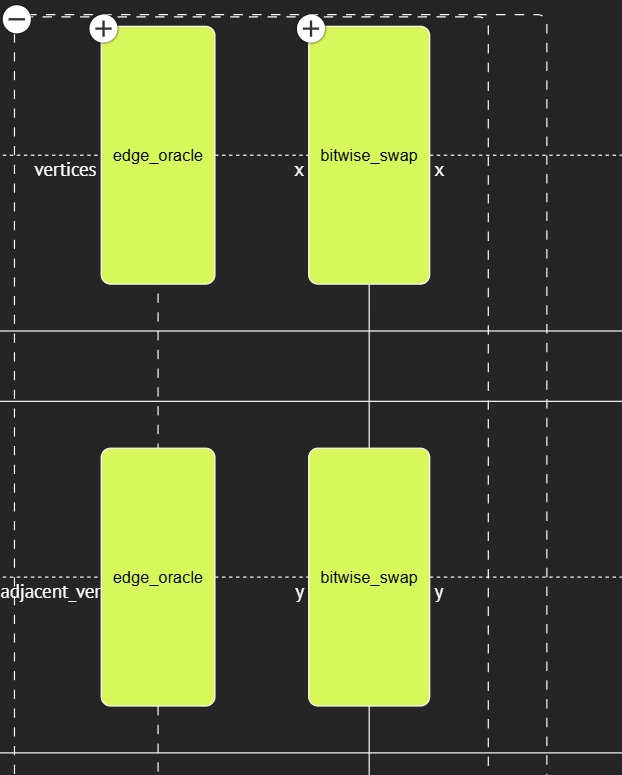

Expansion of S operator: Edge Oracle selects the adjacents edges (j-k)^2 = 1 and a bitwise swap is applied between vertices and adjacent vertices only if they are connected. The SWAP operator stimulates the walker going into the connected edges.